## Convolutional Neural Network (CNN)
#### Convnet for 1 channel
Are Neural Network Architecture that learn feature engineering via **filters**(kernels), </br></br>
CNN concepts : 
1. Filters : 
common **filters**</br></br>
<img src="assets/filters.png">

2. Strides : 
number of pixel shift the kernel over the input image  
3. Padding : 
sometimes filters does not perfectly fit the image , use : 
   * Same : padding the input border with zeros.
   * Valid : drop part of the image where the filter not fit.

we will use same in this expriment.

In [21]:
class config:
    padding = 1
    stride = 1

## Lets Make simple example

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

<img src="assets/img_def.png">

Image is combination of RGB (Red,Green,Blue),</br></br>

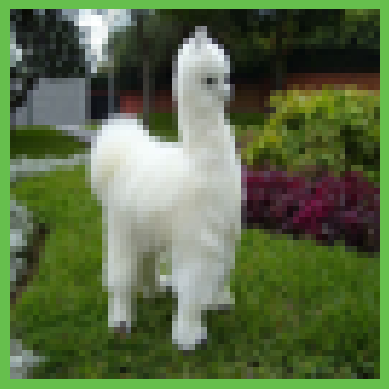

In [23]:
img = Image.open('lama.png')
img = img.resize((64, 64))
img = np.array(img)
plt.figure(facecolor=(0.4, 0.75, 0.3))
plt.axis('off')
plt.imshow(img)

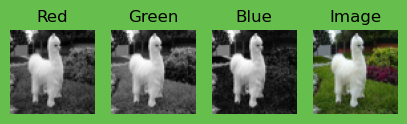

In [24]:
fig, axes = plt.subplots(1, 4, figsize=(5,5),facecolor=(0.4, 0.75, 0.3))
l = ['Red','Green','Blue']
for i in range(0,3):
  axes[i].set_title(l[i])
  axes[i].imshow(img[:,:,i],cmap='gray')
  axes[i].axis('off')
axes[3].set_title('Image')
axes[3].imshow(img,cmap='gray')
axes[3].axis('off')
plt.show()

#### Add Pad to image in border (zeros)

In [25]:
padded_img = []
for i in range(0,3):
  padded_img.append(np.pad(img[:,:,i],(config.padding,config.padding))) # take each channel and pad it

Plot image and after adding pad to it
--------------------------------------------------------------------------------------------


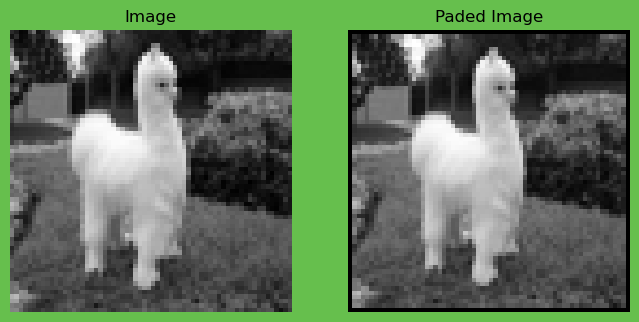

In [26]:
print('Plot image and after adding pad to it')
print('-'*92)
fig, axes = plt.subplots(1, 2, figsize=(8,8),facecolor=(0.4, 0.75, 0.3))

axes[0].set_title("Image")
axes[0].imshow(img[:,:,1],cmap='gray')
axes[0].axis('off')

axes[1].set_title("Paded Image")
axes[1].imshow(padded_img[1],cmap='gray')
axes[1].axis('off')
plt.show()

as you can see the black are 0 , the pad added to the input

In [27]:
pad = np.array(padded_img) # shape now become c,w,h

## Compute the output

In [28]:
class ConvNet:
    def __init__(self,f_n,f_s):
        self.filter_num = f_n
        self.filter_size = f_s
        self.filters = np.random.randn(f_n,f_s,f_s) / (f_s * f_s) # normalize intialization with mean 0,std 1 by multiplying (f_s * f_s)
        
    def patch_and_conv(self,image):
        self.image = image
        width , height, *_ = image.shape
        convolved_img = np.zeros((height-self.filter_size + 1,width-self.filter_size + 1,self.filter_num))

        image_patch = []
        for y in range(0,height - self.filter_size + 1,config.stride) : # (n - f + 1)
            for x in range(0,width - self.filter_size + 1,config.stride):
                image_patch.append(image[y:(y+self.filter_size) , x:(x+self.filter_size)])
                convolved_img[y,x] = np.sum(image[y:(y+self.filter_size) , x:(x+self.filter_size)] * self.filters,axis=(1,2))
        return image_patch,convolved_img
    
    def image_region(self,image):
        self.image = image
        width , height, *_ = image.shape
        convolved_img = np.zeros((height-self.filter_size + 1,width-self.filter_size + 1,self.filter_num))

        for y in range(0,height - self.filter_size + 1,config.stride) : # (n - f + 1)
            for x in range(0,width - self.filter_size + 1,config.stride):
                image_patch = image[y:(y+self.filter_size) , x:(x+self.filter_size)]
                yield image_patch,y,x
    
    def forward_prob(self,image):
        width , height, *_ = image.shape
        
        convolved_img = np.zeros((height-self.filter_size + 1,width-self.filter_size + 1,self.filter_num))
        for img_ptch,i,j in self.image_region(image):
            convolved_img[i,j] = np.sum(img_ptch * self.filters,axis=(1,2)) 
            # axis = (1,2) , means sum cols in depth and return m,n,c => m shape
        return convolved_img
    
    def back_prob(self,dl_out,learning_rate):
        dldf = np.zeros(self.filters.shape)
        for img_ptch,i,j in self.image_region(self.image):
            for k in range(self.filter_num):
                dldf[k] += img_ptch * dl_out[i,j,k]
        self.filters -= learning_rate * dldf
        return dldf

In [29]:
class Pooling:
    def __init__(self,filter_size):
        self.filter_size = filter_size
        
    def image_region(self,image):
        new_height = image.shape[0] // self.filter_size
        new_width = image.shape[1] // self.filter_size

        self.image = image
                
        for i in range(0,new_height) :
            for j in range(0,new_width):
                image_patch = image[(i*self.filter_size) : (i*self.filter_size + self.filter_size) , (j*self.filter_size) : (j*self.filter_size + self.filter_size)]
                yield image_patch,i,j
                
    def pool(self,image,state='max'):
        height,width,filter_nums = image.shape
        out = np.zeros((height//self.filter_size,width//self.filter_size,filter_nums))
        for img_ptch,i,j in self.image_region(image):
            if state =='avg':
                out[i,j] = np.average(img_ptch,axis=(0,1))
            elif state == 'max':
                out[i,j] = np.max(img_ptch,axis=(0,1))
        return out
        

#### Make Convnet with 9 filters of size 9x9

In [30]:
c = ConvNet(9,9)
c.filters.shape

(9, 9, 9)

(-0.5, 55.5, 55.5, -0.5)

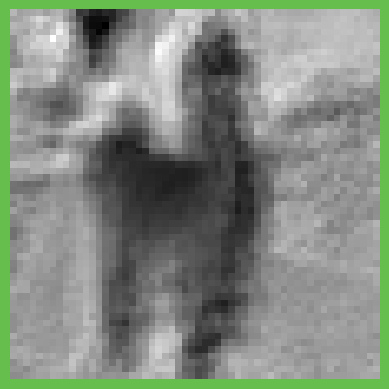

In [44]:
out = c.forward_prob(img[:,:,0])

plt.figure(facecolor=(0.4, 0.75, 0.3))
plt.imshow(out[:,:,6],cmap='gray')
plt.axis('off')

In [45]:
p = Pooling(3)
average = p.pool(out,'avg')
maximum = p.pool(out)
average.shape

(18, 18, 9)

#### Plot both Max,Average Pooling

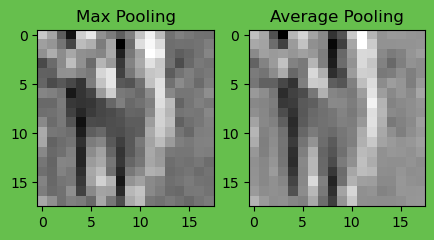

In [46]:
fig, axes = plt.subplots(1, 2, figsize=(5,5),facecolor=(0.4, 0.75, 0.3))
axes[0].set_title('Max Pooling')
axes[0].imshow(maximum[:,:,0],cmap='gray')
axes[1].set_title('Average Pooling')
axes[1].imshow(average[:,:,0],cmap='gray')

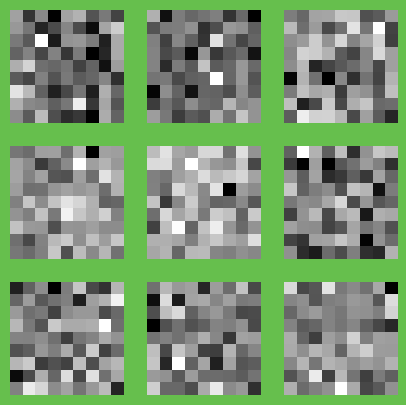

In [47]:
# plot filters
fig, axes = plt.subplots(3, 3, figsize=(5,5),facecolor=(0.4, 0.75, 0.3))
axes = axes.flatten()
for i in range(0,9):
  axes[i].imshow(c.filters[i,:,:],cmap='gray')
  axes[i].axis('off')
plt.show()

### Plot image patches

Image : 
____________________________________________________________________________________________________


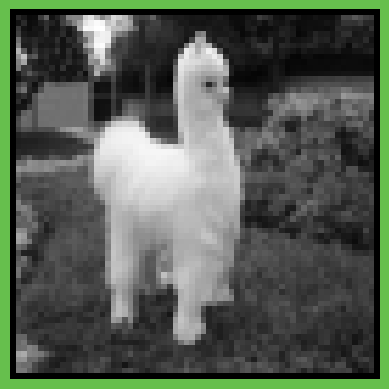

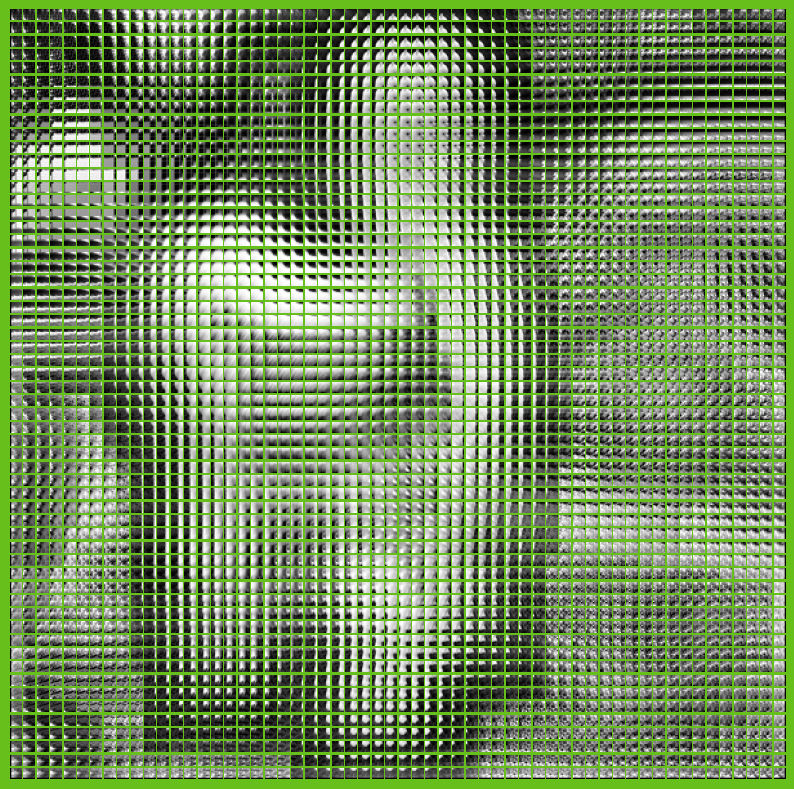

In [35]:
# np.array(img_data).shape
print('Image : ')
print('_'*100)
plt.figure(facecolor=(0.4, 0.75, 0.3))
plt.imshow(pad[0,:,:],cmap='gray')
plt.axis('off')

patches,conv = c.patch_and_conv(pad[0,:,:])

sqrt = int(len(patches)**0.5)

fig, axes = plt.subplots(sqrt,sqrt, figsize=(10,10),facecolor=(0.4, 0.75, 0.1))
axes = axes.flatten()

for i in range(0,len(patches)):
    axes[i].imshow(patches[i],cmap='gray')
    axes[i].axis('off')
plt.show()

### plot Convolved image

In [37]:
conv.shape

(58, 58, 9)

#### show convolved image (after apply filters)

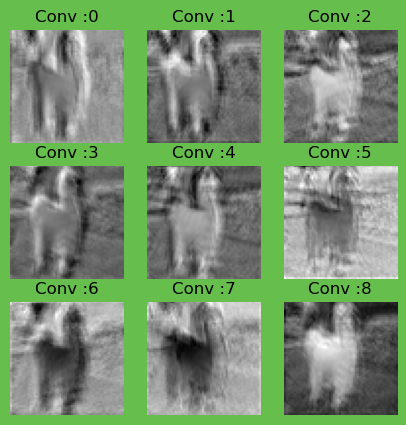

In [38]:
fig, axes = plt.subplots(3, 3, figsize=(5,5),facecolor=(0.4, 0.75, 0.3))
axes = axes.flatten()
for i in range(0,9):
  axes[i].set_title(f'Conv :{i}')
  axes[i].imshow(conv[:,:,i],cmap='gray')
  axes[i].axis('off')
plt.show()

### Increase Filters

In [48]:
conn = ConvNet(18,7)
out = conn.forward_prob(img[:,:,0])
out.shape

(58, 58, 18)

(-0.5, 57.5, 57.5, -0.5)

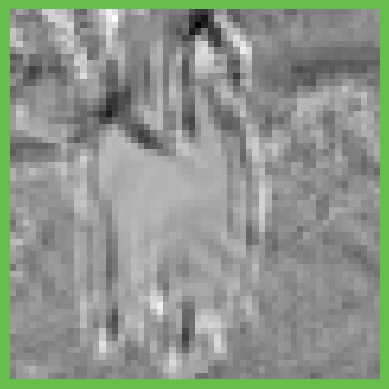

In [49]:
plt.figure(facecolor=(0.4, 0.75, 0.3))
plt.imshow(out[:,:,15],cmap='gray')
plt.axis('off')

In [50]:
grad = conn.back_prob(out,0.001)
grad.shape

(18, 7, 7)

#### Gradient of filters

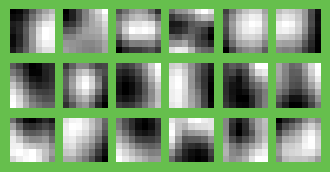

In [51]:
fig, axes = plt.subplots(3, 6, figsize=(4,2),facecolor=(0.4, 0.75, 0.3))

axes = axes.flatten()
for i in range(0,len(grad)):
  axes[i].imshow(grad[i,:,:],cmap='gray')
  axes[i].axis('off')
plt.show()